In [2]:
import numpy as np
import sympy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd



# Finding Stiffness matrix and Mass matrix


Given below is a beam element. It is subject to bending and shear forces as shown below.


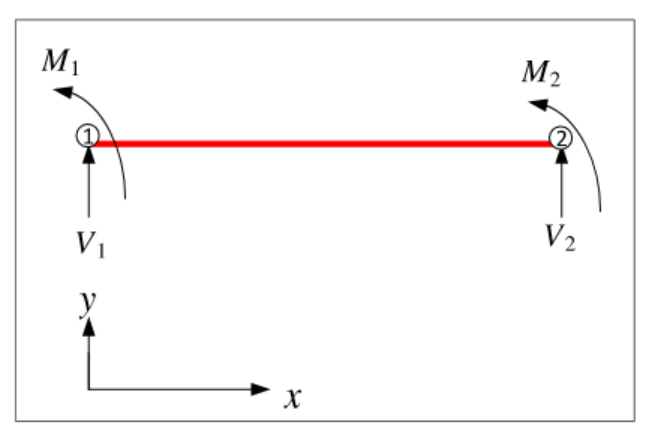





The two nodes are numbered 1 and 2 from left to right. 
- $M_1$ is the moment at the left node (node 1). 
- $M_2$ is the moment at the right node (node 2).
- $V_1$ is the vertical force at the left node. 
- $V_2$ is the vertical force at the right node.

Here, vertical displacement function along $x$ axis is $v(x)$ and angluar displacement function $\theta(x)$ along $x$ is given by $\frac {d}{dx}v(x)$

In [3]:
x = sp.Symbol('x')
θ = sp.Function('θ')(x)

v = sp.Function('v')(x)              # displacement function at distance x
θ = sp.Eq(θ, sp.Derivative(v, x))    # Angular displacement function at distance x

display(θ)


Eq(θ(x), Derivative(v(x), x))

In beam theory the signs are different from what is given in the ﬁrst diagram above. Therefore, the moment and shear forces obtained using beam theory ($M_B$ and $V_B$ in the diagram below) will have different signs when compared to the external forces. The signs are then adjusted to reﬂect the convention as shown in the diagram above using $M$ and $V$.


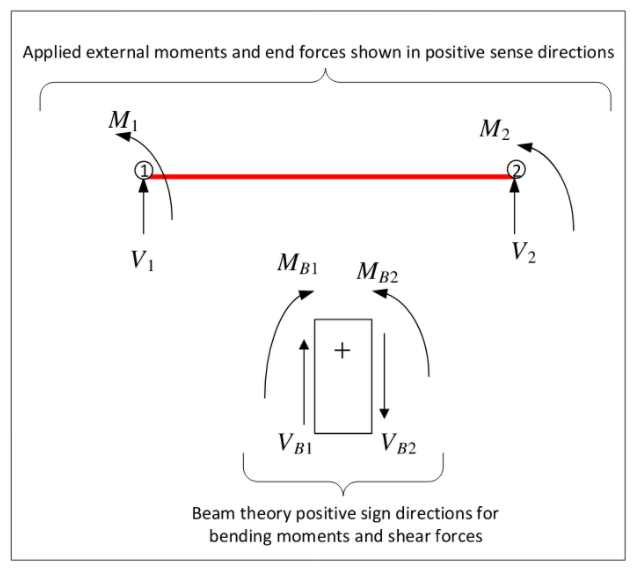


Now, we have to obtain expressions for the external loads $M_i$ and $V_i$ as functions of displacements at the nodes 1 and 2.
$[P] = [K][d]$

where 
$[K]$ is the stiffness matrix
$[P]$ is the nodal forces vector, 

$[P] = \begin{bmatrix}V_1 \\ M_1 \\ V_2 \\ M_2\end{bmatrix}$
$[d]$ is he nodal displacement vector, 
$[d] = \begin{bmatrix}v_1 \\ \theta_1 \\ v_2 \\ \theta_2\end{bmatrix}$

In [4]:
L, I, E, a0, a1, a2, a3, v1, θ1, v2, θ2, rho, A = sp.symbols("L I E a_0 a_1 a_2 a_3 v1 θ_1 v2 θ_2 ρ A")

NODAL_FORCE_VECTOR = np.array([["V1", E*I*sp.Derivative(v, x, 3)], 
                               ["M1", -E*I*sp.Derivative(v, x, 2)], 
                               ["V2", -E*I*sp.Derivative(v, x, 3)], 
                               ["M2", E*I*sp.Derivative(v, x, 2)]])

for i in NODAL_FORCE_VECTOR:
    print(i[0])
    display(i[1])
    print("==========================================")


V1


E*I*Derivative(v(x), (x, 3))

M1


-E*I*Derivative(v(x), (x, 2))

V2


-E*I*Derivative(v(x), (x, 3))

M2


E*I*Derivative(v(x), (x, 2))

To find the nodal displacement vector in RHS, we assume that field displacement $v(x)$ is assumed to be a polynomial of degree 3. 

In [5]:
v = a0 + a1*x + a2*x**2 + a3*x**3
θ = sp.diff(v, x)

print("v(x)")
display(v)

print("========================")

print("θ(x)")
display(θ)

v(x)


a_0 + a_1*x + a_2*x**2 + a_3*x**3

θ(x)


a_1 + 2*a_2*x + 3*a_3*x**2

Here, we need to find 4 degrees of freedom for the given polynomial of degree 3. 

So assuming the length of the beam to be $L$

- $v_1 = v(x) |_{x = 0}$
- $\theta_1 = \theta(x) |_{x = 0}$
- $v_2 = v(x)|_{x = L}$
- $\theta_2 = \theta(x) |_{x = L}$

In [6]:
NODAL_DISPLACEMENT_VECTOR = np.array([
                                      ["v1", v.subs(x, 0)],
                                      ["θ1", θ.subs(x, 0)],
                                      ["v2", v.subs(x, L)],
                                      ["θ2", θ.subs(x, L)]])

for i in NODAL_DISPLACEMENT_VECTOR:
    print(i[0])
    display(i[1])
    print("=================================")


v1


a_0

θ1


a_1

v2


L**3*a_3 + L**2*a_2 + L*a_1 + a_0

θ2


3*L**2*a_3 + 2*L*a_2 + a_1

Solving these 4 equations gives us $a_0, a_1, a_2$ and $a_3$

In [7]:
A_MATRIX = sp.solve((NODAL_DISPLACEMENT_VECTOR[0][1] - v1, 
              NODAL_DISPLACEMENT_VECTOR[1][1] - θ1, 
              NODAL_DISPLACEMENT_VECTOR[2][1] - v2,
              NODAL_DISPLACEMENT_VECTOR[3][1] - θ2), 
              a0, a1, a2, a3)

v = v.subs([(a0, A_MATRIX[a0]), 
            (a1, A_MATRIX[a1]), 
            (a2, A_MATRIX[a2]), 
            (a3, A_MATRIX[a3])])

print("v(x)")
display(v)

v(x)


v1 + x*θ_1 + x**2*(-2*L*θ_1 - L*θ_2 - 3*v1 + 3*v2)/L**2 + x**3*(L*θ_1 + L*θ_2 + 2*v1 - 2*v2)/L**3

Now, this equation can be written as $v(x) = \begin{bmatrix}N_1(x) & N_2(x) & N_3(x) & N_4(x)\end{bmatrix} \begin{bmatrix}v_1 \\ \theta_1 \\ v_2 \\ \theta_2\end{bmatrix}$

where $N_i$ are the shape functions.

In [8]:
v = v.expand()

SHAPE_FUNCTIONS = np.array([v.coeff(v1), 
                            v.coeff(θ1),
                            v.coeff(v2), 
                            v.coeff(θ2)])

for i in range(4):
    print("N" + str(i + 1))
    display(SHAPE_FUNCTIONS[i])
    print("======================================")

N1


1 - 3*x**2/L**2 + 2*x**3/L**3

N2


x - 2*x**2/L + x**3/L**2

N3


3*x**2/L**2 - 2*x**3/L**3

N4


-x**2/L + x**3/L**2

Now, we substitute the value of $v(x)$ in the nodal force vector

In [9]:
NODAL_FORCE_VECTOR[0][1] = E*I*sp.diff(v, x, 3)
NODAL_FORCE_VECTOR[1][1] = -E*I*sp.diff(v, x, 2)
NODAL_FORCE_VECTOR[2][1] = -E*I*sp.diff(v, x, 3)
NODAL_FORCE_VECTOR[3][1] = E*I*sp.diff(v, x, 2)

for i in NODAL_FORCE_VECTOR:
    print(i[0])
    display(i[1])
    print("=====================================")

V1


6*E*I*(θ_1 + θ_2 + 2*v1/L - 2*v2/L)/L**2

M1


-2*E*I*(-2*θ_1 - θ_2 - 3*v1/L + 3*v2/L + 3*x*θ_1/L + 3*x*θ_2/L + 6*v1*x/L**2 - 6*v2*x/L**2)/L

V2


-6*E*I*(θ_1 + θ_2 + 2*v1/L - 2*v2/L)/L**2

M2


2*E*I*(-2*θ_1 - θ_2 - 3*v1/L + 3*v2/L + 3*x*θ_1/L + 3*x*θ_2/L + 6*v1*x/L**2 - 6*v2*x/L**2)/L

Now, we substitute 

- $x = 0$ for $V1$ and $M1$
- $x = L$ for $V2$ and $M2$

In [10]:
NODAL_FORCE_VECTOR[0][1] = NODAL_FORCE_VECTOR[0][1].subs(x, 0)
NODAL_FORCE_VECTOR[1][1] = NODAL_FORCE_VECTOR[1][1].subs(x, 0)
NODAL_FORCE_VECTOR[2][1] = NODAL_FORCE_VECTOR[2][1].subs(x, L)
NODAL_FORCE_VECTOR[3][1] = NODAL_FORCE_VECTOR[3][1].subs(x, L)

for i in NODAL_FORCE_VECTOR:
    print(i[0])
    display(i[1])
    print("=====================================")

V1


6*E*I*(θ_1 + θ_2 + 2*v1/L - 2*v2/L)/L**2

M1


-2*E*I*(-2*θ_1 - θ_2 - 3*v1/L + 3*v2/L)/L

V2


-6*E*I*(θ_1 + θ_2 + 2*v1/L - 2*v2/L)/L**2

M2


2*E*I*(θ_1 + 2*θ_2 + 3*v1/L - 3*v2/L)/L

Now, this is of the form $v(x) = [K] \begin{bmatrix}v_1 \\ \theta_1 \\ v_2 \\ \theta_2\end{bmatrix}$

where $[K]$ is a 4 x 4 matrix.

In [11]:
STIFFNESS_MATRIX = np.array([[NODAL_FORCE_VECTOR[0][1].expand().coeff(v1), NODAL_FORCE_VECTOR[1][1].expand().coeff(v1), NODAL_FORCE_VECTOR[2][1].expand().coeff(v1), NODAL_FORCE_VECTOR[3][1].expand().coeff(v1)], 
                             [NODAL_FORCE_VECTOR[0][1].expand().coeff(θ1), NODAL_FORCE_VECTOR[1][1].expand().coeff(θ1), NODAL_FORCE_VECTOR[2][1].expand().coeff(θ1), NODAL_FORCE_VECTOR[3][1].expand().coeff(θ1)],
                             [NODAL_FORCE_VECTOR[0][1].expand().coeff(v2), NODAL_FORCE_VECTOR[1][1].expand().coeff(v2), NODAL_FORCE_VECTOR[2][1].expand().coeff(v2), NODAL_FORCE_VECTOR[3][1].expand().coeff(v2)], 
                             [NODAL_FORCE_VECTOR[0][1].expand().coeff(θ2), NODAL_FORCE_VECTOR[1][1].expand().coeff(θ2), NODAL_FORCE_VECTOR[2][1].expand().coeff(θ2), NODAL_FORCE_VECTOR[3][1].expand().coeff(θ2)]])

STIFFNESS_MATRIX

array([[12*E*I/L**3, 6*E*I/L**2, -12*E*I/L**3, 6*E*I/L**2],
       [6*E*I/L**2, 4*E*I/L, -6*E*I/L**2, 2*E*I/L],
       [-12*E*I/L**3, -6*E*I/L**2, 12*E*I/L**3, -6*E*I/L**2],
       [6*E*I/L**2, 2*E*I/L, -6*E*I/L**2, 4*E*I/L]], dtype=object)

Mass matrix can be found by

$[M] = \int_0^L\rho A[N]^T[N]dx$

where $[N]$ is the matrix of shape function

$[N] = [N_1(x), N_2(x), N_3(x), N_4(x) ]$

In [12]:
MASS_MATRIX = np.zeros((4, 4), dtype = 'object')

for i in range(4):
    for j in range(4):
        MASS_MATRIX[i][j] = rho*A*sp.integrate(SHAPE_FUNCTIONS[i]*SHAPE_FUNCTIONS[j], (x, L))
    
MASS_MATRIX

array([[13*A*L*ρ/35, 11*A*L**2*ρ/210, 9*A*L*ρ/70, -13*A*L**2*ρ/420],
       [11*A*L**2*ρ/210, A*L**3*ρ/105, 13*A*L**2*ρ/420, -A*L**3*ρ/140],
       [9*A*L*ρ/70, 13*A*L**2*ρ/420, 13*A*L*ρ/35, -11*A*L**2*ρ/210],
       [-13*A*L**2*ρ/420, -A*L**3*ρ/140, -11*A*L**2*ρ/210, A*L**3*ρ/105]],
      dtype=object)

$C_1$ Continuity for the beam with 100 elements

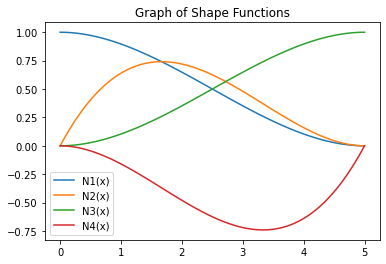

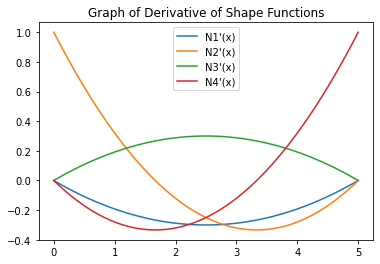

In [13]:
N = 100
LENGTH = 5

C1_X = np.linspace(0, LENGTH, N)

C1_CONTINUITY = np.array([
                        np.zeros(N),
                        np.zeros(N),
                        np.zeros(N),
                        np.zeros(N)
])

for i in range(N):
    C1_CONTINUITY[0][i] = SHAPE_FUNCTIONS[0].subs([(L, LENGTH), (x, C1_X[i])])
    C1_CONTINUITY[1][i] = SHAPE_FUNCTIONS[1].subs([(L, LENGTH), (x, C1_X[i])])
    C1_CONTINUITY[2][i] = SHAPE_FUNCTIONS[2].subs([(L, LENGTH), (x, C1_X[i])])
    C1_CONTINUITY[3][i] = SHAPE_FUNCTIONS[3].subs([(L, LENGTH), (x, C1_X[i])])

for i in range(len(C1_CONTINUITY)):
    plt.plot(C1_X, C1_CONTINUITY[i])
plt.legend(['N1(x)', 'N2(x)', 'N3(x)', 'N4(x)'])
plt.title("Graph of Shape Functions")
plt.show()

C1_CONT_D = np.array([
                        np.zeros(N),
                        np.zeros(N),
                        np.zeros(N),
                        np.zeros(N)
])

for i in range(N):
    C1_CONT_D[0][i] = sp.diff(SHAPE_FUNCTIONS[0], x).subs([(L, LENGTH), (x, C1_X[i])])
    C1_CONT_D[1][i] = sp.diff(SHAPE_FUNCTIONS[1], x).subs([(L, LENGTH), (x, C1_X[i])])
    C1_CONT_D[2][i] = sp.diff(SHAPE_FUNCTIONS[2], x).subs([(L, LENGTH), (x, C1_X[i])])
    C1_CONT_D[3][i] = sp.diff(SHAPE_FUNCTIONS[3], x).subs([(L, LENGTH), (x, C1_X[i])])

for i in range(len(C1_CONTINUITY)):
    plt.plot(C1_X, C1_CONT_D[i])
plt.legend(["N1'(x)", "N2'(x)", "N3'(x)", "N4'(x)"])
plt.title("Graph of Derivative of Shape Functions")
plt.show()

In [14]:
# declaring values

L = 5                          # length in m
B = 0.5                        # breadth in m
H = 0.5                        # height in m
E = 7E10                       # modulus of elasticity in N/m^4
D = 2700                       # density in Kg/m^3
    
A = B*H                        # area in m^2
I = (B*H**3)/12                # area moment of inertia in m^4
N = 100                        # number of elements taken
# LENGTHVECTOR = [np.linspace(0, LENGTH, i + 1) for i in N_ELEMENTS]
m = 5                          # number of modeshapes
X = np.linspace(0, 5, 101)
X_N = np.arange(5, 100, 1)

In [15]:
def make_csv(data, name):
    df = pd.DataFrame(data)
    name += '.csv'  
    df.to_csv(name, index = None, header = None)

def make_stiffness_matrix(n):
    k_matrix = np.array([
                         [12*E*I/(L/n)**3, 6*E*I/(L/n)**2, -12*E*I/(L/n)**3, 6*E*I/(L/n)**2],
                         [6*E*I/(L/n)**2, 4*E*I/(L/n), -6*E*I/(L/n)**2, 2*E*I/(L/n)],
                         [-12*E*I/(L/n)**3, -6*E*I/(L/n)**2, 12*E*I/(L/n)**3, -6*E*I/(L/n)**2],
                         [6*E*I/(L/n)**2, 2*E*I/(L/n), -6*E*I/(L/n)**2, 4*E*I/(L/n)]
                         ])
    
    stiffness_matrix = np.zeros((2*n + 2, 2*n + 2), dtype = 'float')
    i, j = 0, 0
    counti, countj = 0, 0

    while i < 2*n + 2:
        while j < 2*n + 2:
            stiffness_matrix[i][j] += k_matrix[counti][countj]
            j += 1
            countj += 1
            if countj == 4:
                if counti != 3:
                    i += 1
                    countj = 0
                    j -= 4
                    counti += 1
                    continue
                if counti == 3:
                    if i == 2*n + 1:
                        break
                    j -= 2
                    i -= 1
                    counti, countj = 0, 0
        break
    return stiffness_matrix
    
def make_mass_matrix(n):
    m_matrix = np.array([[13*A*(L/n)*D/35, 11*A*((L/n)**2)*D/210, 9*A*(L/n)*D/70, -13*A*((L/n)**2)*D/420],
       [11*A*((L/n)**2)*D/210, A*((L/n)**3)*D/105, 13*A*((L/n)**2)*D/420, -A*((L/n)**3)*D/140],
       [9*A*(L/n)*D/70, 13*A*((L/n)**2)*D/420, 13*A*(L/n)*D/35, -11*A*((L/n)**2)*D/210],
       [-13*A*((L/n)**2)*D/420, -A*((L/n)**3)*D/140, -11*A*((L/n)**2)*D/210, A*((L/n)**3)*D/105]
       ])
    
    mass_matrix = np.zeros((2*n + 2, 2*n + 2), dtype = 'float')
    i, j = 0, 0
    counti, countj = 0, 0

    while i < 2*n + 2:
        while j < 2*n + 2:
            mass_matrix[i][j] += m_matrix[counti][countj]
            j += 1
            countj += 1
            if countj == 4:
                if counti != 3:
                    i += 1
                    countj = 0
                    j -= 4
                    counti += 1
                    continue
                if counti == 3:
                    if i == 2*n + 1:
                        break
                    j -= 2
                    i -= 1
                    counti, countj = 0, 0
        break
    return mass_matrix


# Modeshapes and Convergence for Fixed - Free beam

In [19]:
STIFFNESS_MATRIX = make_stiffness_matrix(N)
# make_csv(STIFFNESS_MATRIX, "K")

MASS_MATRIX = make_mass_matrix(N)
# make_csv(MASS_MATRIX, "M")

# Fixed - Free beam

STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[0:2], 0)
STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[0:2], 1)

MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[0:2], 0)
MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[0:2], 1)

evals, evecs = la.eigh(STIFFNESS_MATRIX, MASS_MATRIX)
print(np.sqrt(evals)/(2*np.pi))
"""
# make_csv(evals, "evals")
# make_csv(evecs, "evecs")

MODES = []

for i in range(m):
    mod = [0]
    for j in range(len(evecs)):
        if j % 2 == 0:
            mod.append(evecs[j][i])
    MODES.append(mod)
# make_csv(MODES, "modes")

for i in MODES:
    plt.plot(X, i)
plt.title("First 5 modeshapes of Fixed - Free beam")
plt.legend(['1st mode', '2nd mode', '3rd mode', '4th mode', '5th mode'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Length')
plt.ylabel('Deflection')
plt.show()
print("=================================================")

CONVERGENCE_FIFR = []

for N_element in range(5, 100):
    STIFFNESS_MATRIX = make_stiffness_matrix(N_element)
    # make_csv(STIFFNESS_MATRIX, "K")

    MASS_MATRIX = make_mass_matrix(N_element)
    # make_csv(MASS_MATRIX, "M")

    # Fixed - Free beam

    STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[0:2], 0)
    STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[0:2], 1)

    MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[0:2], 0)
    MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[0:2], 1)

    evals, evecs = la.eigh(STIFFNESS_MATRIX, MASS_MATRIX)

    CONVERGENCE_FIFR.append(np.sqrt(evals[0])/(2*np.pi))


plt.plot(X_N, CONVERGENCE_FIFR)
plt.ticklabel_format(useOffset=False)
plt.title("Convergence of Fixed - Free beam")
plt.xlabel('Number of Elements')
plt.ylabel('Frequency')
plt.show()
"""

[6.07886613e-02 9.69996845e-03 3.46423855e-03 1.76782850e-03
 1.06942018e-03 7.15892756e-04 5.12561964e-04 3.84990629e-04
 2.99732773e-04 2.39951803e-04 1.96422601e-04 1.63746798e-04
 1.38594646e-04 1.18821869e-04 1.02997033e-04 9.01349857e-05
 7.95397357e-05 7.07082740e-05 6.32697507e-05 5.69458958e-05
 5.15246084e-05 4.68419360e-05 4.27695304e-05 3.92057565e-05
 3.60692882e-05 3.32944263e-05 3.08276290e-05 2.86249087e-05
 2.66498573e-05 2.48721308e-05 2.32662768e-05 2.18108178e-05
 2.04875288e-05 1.92808639e-05 1.81774971e-05 1.71659524e-05
 1.62363041e-05 1.53799322e-05 1.45893213e-05 1.38578955e-05
 1.31798802e-05 1.25501884e-05 1.19643246e-05 1.14183037e-05
 1.09085836e-05 1.04320072e-05 9.98575306e-06 9.56729381e-06
 9.17435989e-06 8.80490874e-06 8.45709807e-06 8.12926278e-06
 7.81989487e-06 7.52762604e-06 7.25121243e-06 6.98952128e-06
 6.74151928e-06 6.50626224e-06 6.28288607e-06 6.07059877e-06
 5.86867334e-06 5.67644149e-06 5.49328806e-06 5.31864607e-06
 5.15199226e-06 4.992843

'\n# make_csv(evals, "evals")\n# make_csv(evecs, "evecs")\n\nMODES = []\n\nfor i in range(m):\n    mod = [0]\n    for j in range(len(evecs)):\n        if j % 2 == 0:\n            mod.append(evecs[j][i])\n    MODES.append(mod)\n# make_csv(MODES, "modes")\n\nfor i in MODES:\n    plt.plot(X, i)\nplt.title("First 5 modeshapes of Fixed - Free beam")\nplt.legend([\'1st mode\', \'2nd mode\', \'3rd mode\', \'4th mode\', \'5th mode\'], bbox_to_anchor=(1.05, 1), loc=\'upper left\')\nplt.xlabel(\'Length\')\nplt.ylabel(\'Deflection\')\nplt.show()\nprint("=================================================")\n\nCONVERGENCE_FIFR = []\n\nfor N_element in range(5, 100):\n    STIFFNESS_MATRIX = make_stiffness_matrix(N_element)\n    # make_csv(STIFFNESS_MATRIX, "K")\n\n    MASS_MATRIX = make_mass_matrix(N_element)\n    # make_csv(MASS_MATRIX, "M")\n\n    # Fixed - Free beam\n\n    STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[0:2], 0)\n    STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[0:2], 

# Modeshapes and Convergence for Fixed - Fixed beam

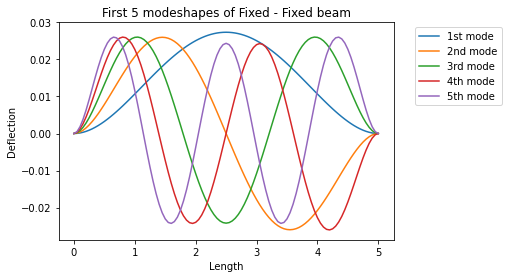

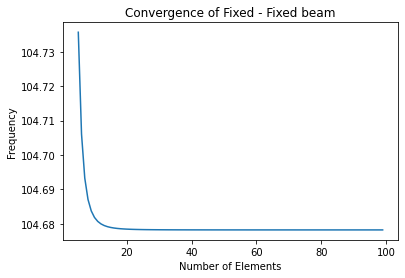

In [ ]:
STIFFNESS_MATRIX = make_stiffness_matrix(N)
# make_csv(STIFFNESS_MATRIX, "K")

MASS_MATRIX = make_mass_matrix(N)
# make_csv(MASS_MATRIX, "M")

# Fixed - Fixed beam

STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[0:2], 0)
STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[0:2], 1)
STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[-2:], 0)
STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[-2:], 1)


MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[0:2], 0)
MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[0:2], 1)
MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[-2:], 0)
MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[-2:], 1)


evals, evecs = la.eigh(STIFFNESS_MATRIX, MASS_MATRIX)

print(evals)
# Convergence

# make_csv(evals, "evals")
# make_csv(evecs, "evecs")

MODES = []

for i in range(m):
    mod = [0]
    for j in range(len(evecs)):
        if j % 2 == 0:
            mod.append(evecs[j][i])
    mod.append(0)
    MODES.append(mod)
# make_csv(MODES, "modes")

for i in MODES:
    plt.plot(X, i)
plt.title("First 5 modeshapes of Fixed - Fixed beam")
plt.legend(['1st mode', '2nd mode', '3rd mode', '4th mode', '5th mode'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Length')
plt.ylabel('Deflection')
plt.show()
print("=============================================")

CONVERGENCE_FIFI = []

for N_element in range(5, 100):
    STIFFNESS_MATRIX = make_stiffness_matrix(N_element)
    # make_csv(STIFFNESS_MATRIX, "K")

    MASS_MATRIX = make_mass_matrix(N_element)
    # make_csv(MASS_MATRIX, "M")

    # Fixed - Fixed beam

    STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[0:2], 0)
    STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[0:2], 1)
    STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[-2:], 0)
    STIFFNESS_MATRIX = np.delete(STIFFNESS_MATRIX, np.s_[-2:], 1)


    MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[0:2], 0)
    MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[0:2], 1)
    MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[-2:], 0)
    MASS_MATRIX = np.delete(MASS_MATRIX, np.s_[-2:], 1)

    evals, evecs = la.eigh(STIFFNESS_MATRIX, MASS_MATRIX)

    CONVERGENCE_FIFI.append(np.sqrt(evals[0])/(2*np.pi))


plt.plot(X_N, CONVERGENCE_FIFI)
plt.ticklabel_format(useOffset=False)
plt.title("Convergence of Fixed - Fixed beam")
plt.xlabel('Number of Elements')
plt.ylabel('Frequency')
plt.show()

# Modeshapes and Convergence of Free - Free beam

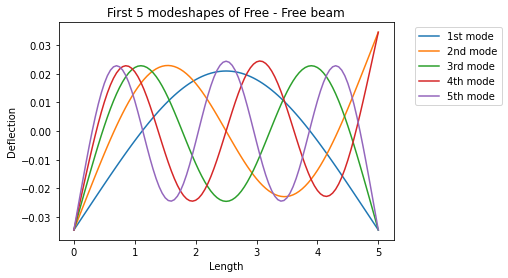

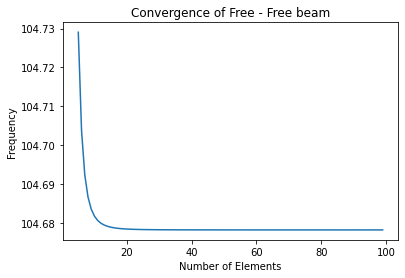

In [ ]:
STIFFNESS_MATRIX = make_stiffness_matrix(N)
# make_csv(STIFFNESS_MATRIX, "K")

MASS_MATRIX = make_mass_matrix(N)
# make_csv(MASS_MATRIX, "M")

# Free - Free beam

evals, evecs = la.eigh(STIFFNESS_MATRIX, MASS_MATRIX)

# Convergence

# make_csv(evals, "evals")
# make_csv(evecs, "evecs")

MODES = []

for i in range(2, m + 2):
    mod = []
    for j in range(len(evecs)):
        if j % 2 == 0:
            mod.append(evecs[j][i])
    MODES.append(mod)
# make_csv(MODES, "modes")


for i in MODES:
    plt.plot(X, i)
plt.title("First 5 modeshapes of Free - Free beam")
plt.legend(['1st mode', '2nd mode', '3rd mode', '4th mode', '5th mode'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Length')
plt.ylabel('Deflection')
plt.show()
print("=============================================")

CONVERGENCE_FRFR = []

for N_element in range(5, 100):
    STIFFNESS_MATRIX = make_stiffness_matrix(N_element)
    # make_csv(STIFFNESS_MATRIX, "K")

    MASS_MATRIX = make_mass_matrix(N_element)
    # make_csv(MASS_MATRIX, "M")

    # Free - Free beam

    evals, evecs = la.eigh(STIFFNESS_MATRIX, MASS_MATRIX)

    CONVERGENCE_FRFR.append(np.sqrt(evals[2])/(2*np.pi))


plt.plot(X_N, CONVERGENCE_FRFR)
plt.ticklabel_format(useOffset=False)
plt.title("Convergence of Free - Free beam")
plt.xlabel('Number of Elements')
plt.ylabel('Frequency')
plt.show()


In [7]:
a = np.array([
              [4, 5, 6, 8],
              [4, 3, 5, 6],
              [7, 8, 9, 0],
              [3, 4, 5, 6]
])

b = sp.Matrix(a)
print(len(b))

16
